**This Notebook was runned on Google Colab**

# **Cameroon Advance Analytic Ultrasound Imageby Camair-AI**

*Given ultrasounds of kidneys can you detect renal failure?*

https://zindi.africa/competitions/cameroon-hackathon-2023/leaderboard


**Description**

Most advanced analytic tools used in Africa, especially in the healthcare sector were developed by others. As a result, products are not well targeted to meet our (Africa’s) specific needs. This is our opportunity to change the narrative to not only use products but drive innovation that can change Africa and the world. This challenge is Camair-AI’s first project to begin blazing a new path.

The objective of this challenge is to build a machine learning model that can predict if kidneys are in renal failure from ultrasounds and to build a hub of data scientists and analysts in Cameroon.

This solution will be useful in a clinical diagnostic tool used to support clinical decision-making in remote areas. These solutions have the potential to grow into tools to monitor a patient's kidney function and determine treatment plans and hopefully, one day a mobile app to monitor multiple aspects of kidney health. The images are from the Cameroon Health System.


NAME: EBIENDELE EMMANUEL



ZINDI USERNAME : Ebiendele


PUBLIC LEADERBOARD SCORE: **0.984848484**


PRIVATE LEADERBOARD SCORE:  **1**


## Importing of Necessary Libraries

In [1]:
!pip install fastai

In [2]:
from fastai.vision.all import *
from fastai.vision import *
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import os

# No need to reload the notebook if any change in the fastai library
%reload_ext autoreload
%autoreload 2

# Display images in the notebook
%matplotlib inline

## Dataset Loading

In [3]:
#@markdown <br><center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/d/da/Google_Drive_logo.png/600px-Google_Drive_logo.png' height="150" alt="Gdrive-logo"/></center>
#@markdown <center><h2>Mount GDrive to /content/drive</h3></center><br>
MODE = "MOUNT" #@param ["MOUNT", "UNMOUNT"]
#Mount your Gdrive!
from google.colab import drive
drive.mount._DEBUG = False
if MODE == "MOUNT":
  drive.mount('/content/drive', force_remount=True)
elif MODE == "UNMOUNT":
  try:
    drive.flush_and_unmount()
  except ValueError:
    pass
  get_ipython().system_raw("rm -rf /root/.config/Google/DriveFS")

Mounted at /content/drive


In [5]:
train = pd.read_csv('/content/drive/MyDrive/CamirAI23/Train.csv')
test = pd.read_csv('/content/drive/MyDrive/CamirAI23/Test.csv')

train['img_IDs'] = train['img_IDs'] + '.jpg'
test['img_IDs'] = test['img_IDs'] + '.jpg'

train.to_csv('train_ai.csv')
test.to_csv('test_ai.csv')

In [6]:
# path to the folder where the datasets are located in my google drive
path = '/content/drive/MyDrive/CamirAI23'  #/content/drive/MyDrive/CamirAI23/Images

train_labels = pd.read_csv("/content/train_ai.csv")

train_fnames = list(map(lambda x : os.path.join(path, "Images/") + x, train_labels['img_IDs']))
labels = train_labels['target']

test = pd.read_csv("/content/test_ai.csv")
test_fnames = list(map(lambda x : os.path.join(path, "Images/" + x), test['img_IDs']))

sample_sub_v2 = pd.read_csv("/content/drive/MyDrive/CamirAI23/SampleSubmission.csv")

train_labels.shape, test.shape, sample_sub_v2.shape

((100, 3), (34, 2), (34, 2))

In [7]:
train_labels.drop(['Unnamed: 0'],inplace=True,axis=1)
test.drop(['Unnamed: 0'],inplace=True,axis=1)

train_labels.shape, test.shape, sample_sub_v2.shape

((100, 2), (34, 1), (34, 2))

In [8]:
sample_sub_v2.shape

(34, 2)

## Sample Images


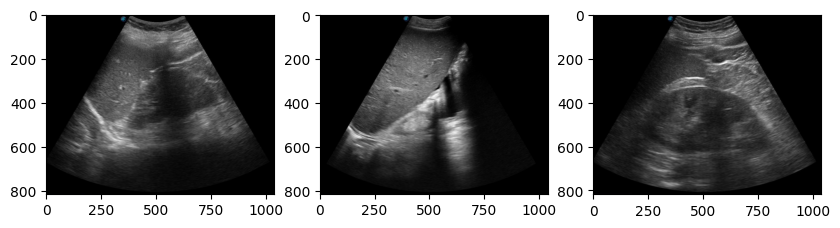

In [9]:
fig, axs = plt.subplots(1,3,figsize=(10,10))
for i, ax in enumerate(axs.flatten()):
    img = plt.imread(train_fnames[i])
    ax.imshow(img)
plt.show()

## Transforming and augmenting images

In [10]:
img = PILImage(PILImage.create(img))

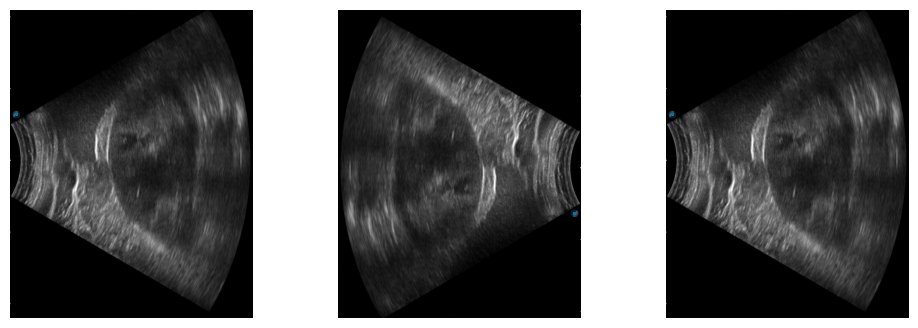

In [11]:
tflip = FlipItem(p=1.)
bbox = TensorBBox(((tensor([[1.,0., 2.,1]]) -1)[None]))
test_eq(tflip(bbox,split_idx=0), tensor([[1.,0., 0.,1]]) -1)

_,axs = plt.subplots(1,3,figsize=(12,4))
for ax in axs.flatten():
    show_image(DihedralItem(p=1.)(img, split_idx=0), ctx=ax)

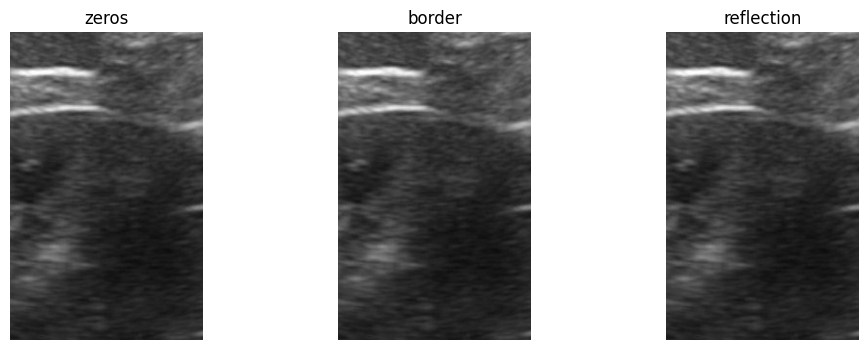

In [12]:
_,axs = plt.subplots(1,3,figsize=(12,4))
for ax,mode in zip(axs.flatten(), [PadMode.Zeros, PadMode.Border, PadMode.Reflection]):
    show_image(img.crop_pad((200,320), pad_mode=mode), ctx=ax, title=mode);

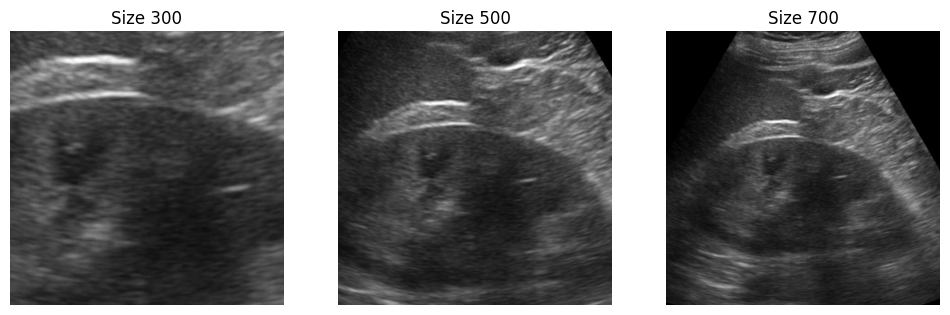

In [13]:
_,axs = plt.subplots(1,3,figsize=(12,4))
for ax,sz in zip(axs.flatten(), [300, 500, 700]):
    show_image(img.crop_pad(sz), ctx=ax, title=f'Size {sz}');

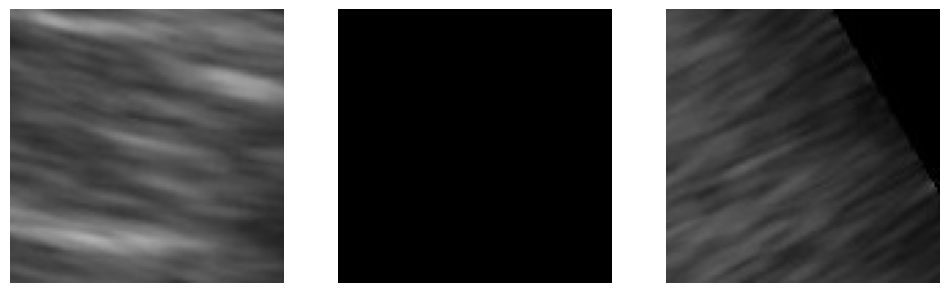

In [14]:
_,axs = plt.subplots(1,3,figsize=(12,4))
f = RandomCrop(100)
for ax in axs: show_image(f(img), ctx=ax);

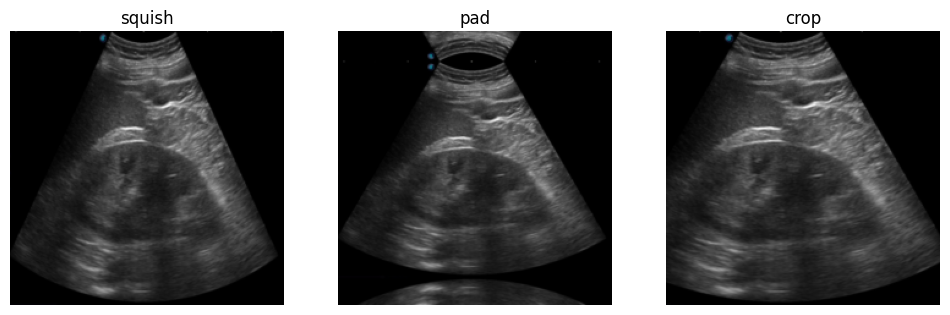

In [15]:
_,axs = plt.subplots(1,3,figsize=(12,4))
for ax,method in zip(axs.flatten(), [ResizeMethod.Squish, ResizeMethod.Pad, ResizeMethod.Crop]):
    rsz = Resize(224, method=method)
    show_image(rsz(img, split_idx=0), ctx=ax, title=method);

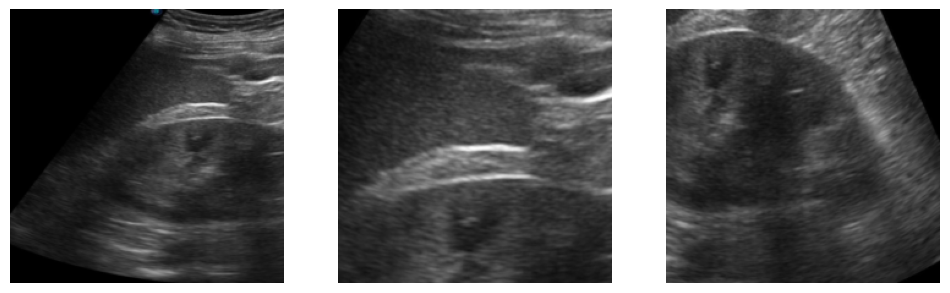

In [16]:
crop = RandomResizedCrop(224)
_,axs = plt.subplots(1,3,figsize=(12,4))
for ax in axs.flatten():
    cropped = crop(img)
    show_image(cropped, ctx=ax);

## Define the image data loader

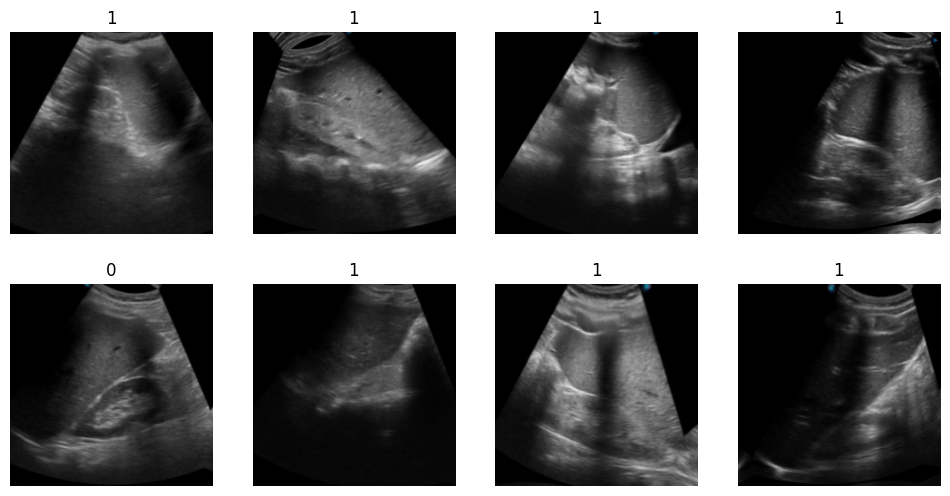

In [17]:
# Define the augmentation pipeline
transforms = aug_transforms(max_rotate=180, max_zoom=1.15, max_lighting=0.4, max_warp=0.4, p_affine=1., p_lighting=1.)
batch_tfms = [*aug_transforms(size=224, max_warp=.35), Normalize.from_stats(*imagenet_stats)]
item_tfms = RandomResizedCrop(224, min_scale=0.75, ratio=(1.,1.))
bs=8 # batch_size

# Load the images to the image data loader via the augmentation pipeline and receive augmented images
dls = ImageDataLoaders.from_lists(path, train_fnames, labels,  batch_tfms=batch_tfms,  ds_tfms=transforms,
                                   item_tfms=item_tfms, bs = bs)
dls.show_batch()

## Using the Resnet34 pretrained model

In [18]:

model = resnet34

In [19]:
roc = RocAucBinary()
learn = vision_learner(dls, model, loss_func=CrossEntropyLossFlat(),
                       ps=0.018, metrics=[accuracy, error_rate, roc]) # ps was used to split the dataset into: Training set(99,5%), Validation set(1,5%).

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 196MB/s]


In [20]:
learn.dls.vocab

[0, 1]

## Fine tune the model

In [21]:
# Find the optimal lr using lr_find()
#learn.lr_find()

In [24]:
# fine tune the model with learning rate and some freeze epochs
#set the freeze_epochs as 1 i.e. number of epochs for which the fine-tuning of the model is done.
#Then we fit the model for 5 epochs
learn.fine_tune(350, base_lr=3e-3, freeze_epochs=1)

epoch,train_loss,valid_loss,accuracy,error_rate,roc_auc_score,time
0,0.005291,1.116388,0.750000,0.250000,0.818182,00:01


epoch,train_loss,valid_loss,accuracy,error_rate,roc_auc_score,time
0,0.000184,1.459231,0.750000,0.250000,0.818182,00:01
1,0.000703,1.505569,0.750000,0.250000,0.818182,00:03
2,0.000794,1.562622,0.750000,0.250000,0.808081,00:02
3,0.001381,1.339960,0.750000,0.250000,0.818182,00:01
4,0.001075,1.300382,0.750000,0.250000,0.828283,00:01
5,0.000831,1.325421,0.750000,0.250000,0.838384,00:01
6,0.000650,1.452856,0.750000,0.250000,0.838384,00:01
7,0.000521,1.612506,0.750000,0.250000,0.838384,00:02
8,0.000464,1.472232,0.750000,0.250000,0.838384,00:03
9,0.000398,1.519145,0.750000,0.250000,0.838384,00:01


## Final Evaluation

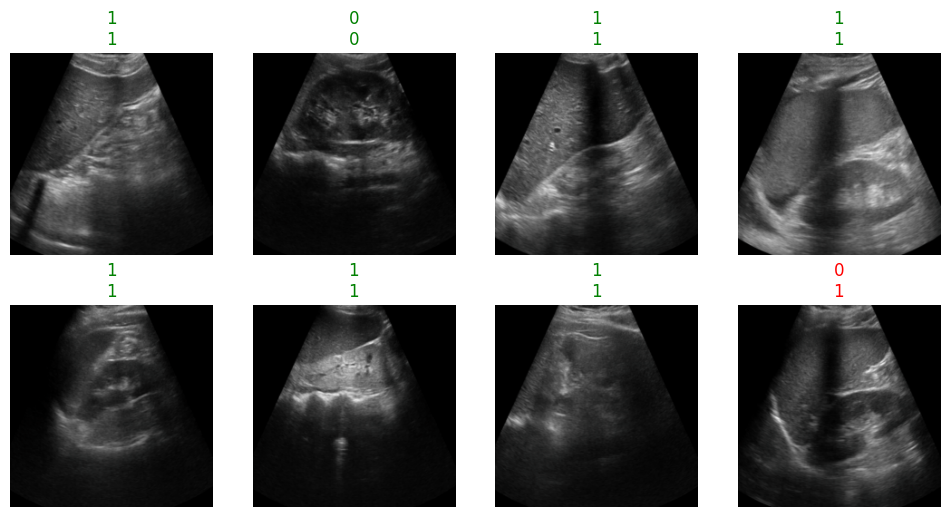

In [25]:
learn.show_results(ds_idx=1, dl=None, max_n=9, shuffle=True)

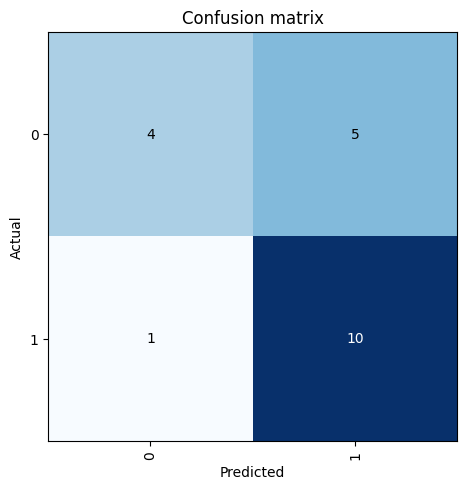

In [26]:
# create the interepreation object from our model
interep = ClassificationInterpretation.from_learner(learn)

# Plot the confusion matrix
interep.plot_confusion_matrix()

## Show prediction tensors of a training image

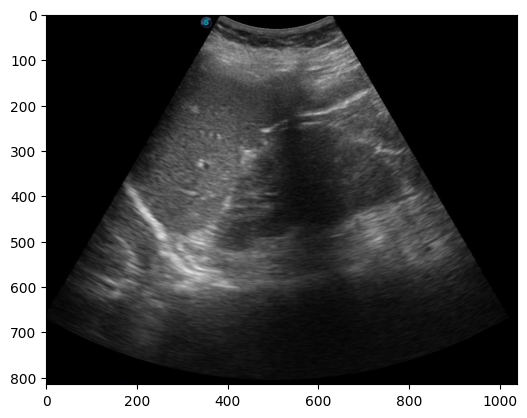

In [27]:
image = plt.imread(train_fnames[0])
plt.imshow(image)

In [28]:
learn.predict(train_fnames[0]) # Geting the predicted Label for the image and then the probabilities

('0', tensor(0), tensor([9.9958e-01, 4.2204e-04]))

In [29]:
preds = learn.get_preds(dl=dls.test_dl(test_fnames))

In [30]:
preds[0][0], np.argsort(preds[0])[0] # We have probs and then labels

(tensor([9.8081e-04, 9.9902e-01]), tensor([0, 1]))

In [32]:
sub = pd.read_csv('/content/drive/MyDrive/CamirAI23/SampleSubmission.csv')

In [34]:
#sample_sub_v2['Label'] = np.argsort(preds[0])[:,1] # If you want to get the labels (0 and 1)
sub['target'] = preds[0][:,1] # To get the predicted probs
sub['img_IDs'] = [''.join(x.split('/')[-1]) for x in test_fnames]
sub = sub[['img_IDs', 'target']]
sub.to_csv('cma5.csv', index=False) # save and submits

sub1 = pd.read_csv('/content/drive/MyDrive/CamirAI23/SampleSubmission.csv')
target_ = sub['target']
#final submission
submission = pd.DataFrame({"img_IDs":sub1['img_IDs'], "target": target_ })
submission.to_csv("winso4.csv", index=False)